# 1. Download Dataset and observe

In [ ]:
! git clone https://github.com/wandakinasih/gg2.git

Cloning into 'gg2'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 11 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (11/11), done.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mv "/content/gg2/cookie_cats.csv" "/content/drive/MyDrive/Generasi Gigih/Last Showcase"

In [3]:
import pandas as pd
import numpy as np

In [4]:
data = pd.read_csv('/content/drive/MyDrive/Generasi Gigih/Last Showcase/cookie_cats.csv')

In [ ]:
data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB




---

Catatan Deskripsi Dataset : 

1. userid : A unique number that identifies each player.
2. version : Whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40).
3. sum_gamerounds : The number of game rounds played by the player during the first 14 days after install.
4. retention_1 : Did the player come back and play 1 day after installing?
5. retention_7 : Did the player come back and play 7 days after installing?

# 1. Check Null Value

## A. User ID

In [ ]:
# mencari data bernilai null dari masing-masing kolom

count_missing_value = data.isnull().sum()
print(count_missing_value)

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64


In [ ]:
# Pandas Index.nunique() function return number of unique elements in the object.
print(data.userid.nunique())

90189


## B. Version

In [ ]:
data.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44700,17.0,52.456264,256.716423,49854
gate_40,45489,16.0,51.298776,103.294416,2640


## C. Sum Game Round

In [ ]:
data.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["sum_gamerounds"]].T

,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
sum_gamerounds,90189.0,51.872457,195.050858,0.0,0.0,1.0,1.0,3.0,16.0,67.0,134.0,221.0,493.0,49854.0


# 2. Cek Outlier

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

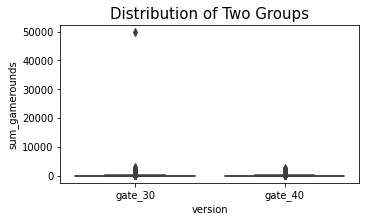

In [6]:
sns.boxplot(x = data.version, y = data.sum_gamerounds).set_title("Distribution of Two Groups", fontsize = 15)

plt.tight_layout(pad = 4);

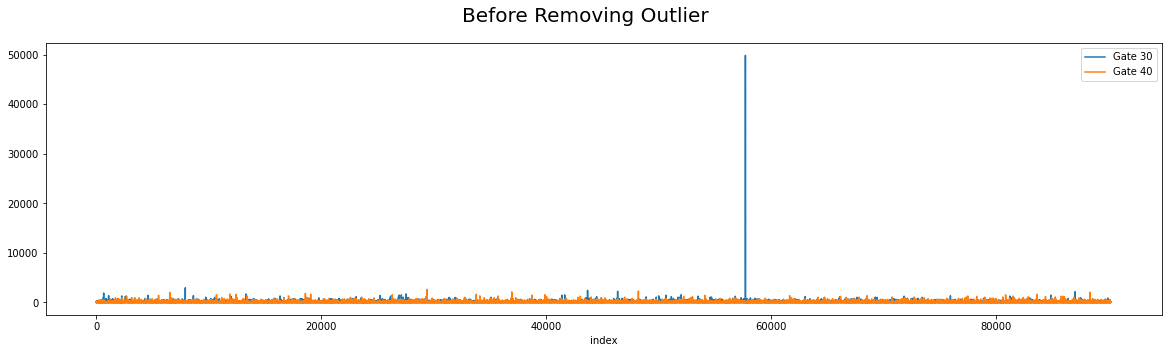

In [7]:
data[data.version == "gate_30"].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 30", figsize = (20,5))
data[data.version == "gate_40"].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 40")
plt.suptitle("Before Removing Outlier", fontsize = 20);

In [ ]:
quartile_9 = data["sum_gamerounds"].quantile(0.99)

In [ ]:
print(quartile_9)

493.0


In [8]:
data_clear = data[data['sum_gamerounds'] < data['sum_gamerounds'].max()]

In [ ]:
data_clear.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["sum_gamerounds"]].T

,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
sum_gamerounds,90188.0,51.320253,102.682719,0.0,0.0,1.0,1.0,3.0,16.0,67.0,134.0,221.0,493.0,2961.0


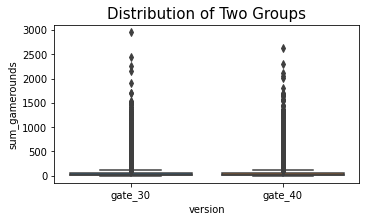

In [9]:
sns.boxplot(x = data_clear.version, y = data_clear.sum_gamerounds).set_title("Distribution of Two Groups", fontsize = 15)

plt.tight_layout(pad = 4);

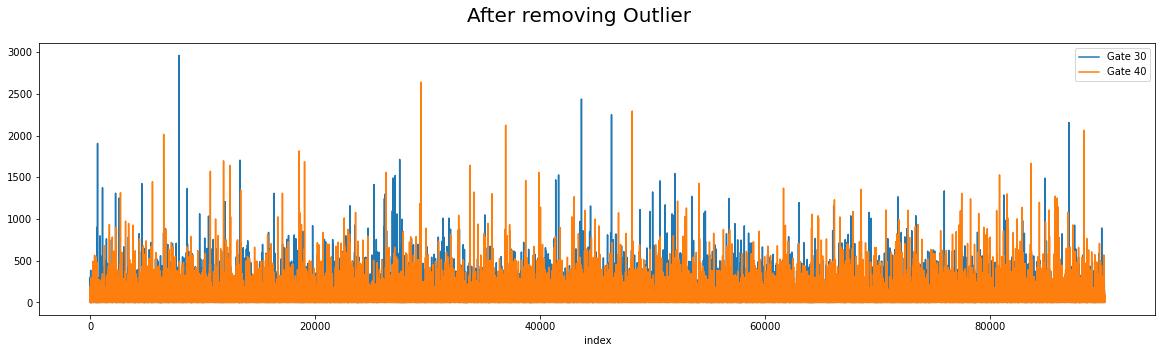

In [10]:
data_clear[data_clear.version == "gate_30"].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 30", figsize = (20,5))
data_clear[data_clear.version == "gate_40"].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 40")
plt.suptitle("After removing Outlier", fontsize = 20);

In [ ]:
data_clear.groupby('version').userid.agg(['count'])


,count
version,
gate_30,44699
gate_40,45489



# 3. Preprocessing Lanjutan

1. cek distribusi data 
2. delete segmentasi yang menjadikan hasil menjadi bias 
3. Menyeimbangkan jumlah data 50% gate_30 50% gate _40 
4. replace value yang bernilai True = 1, dan False = 0

## persentase Retensi User yang bermain game dan tidak semenjak instal pada hari pertama dan ke-delapan

In [11]:
retention_1 = data_clear['retention_1'].value_counts()
print(retention_1)

False    50035
True     40153
Name: retention_1, dtype: int64


In [12]:
retention_7 = data_clear['retention_7'].value_counts()
print(retention_7)

False    73408
True     16780
Name: retention_7, dtype: int64


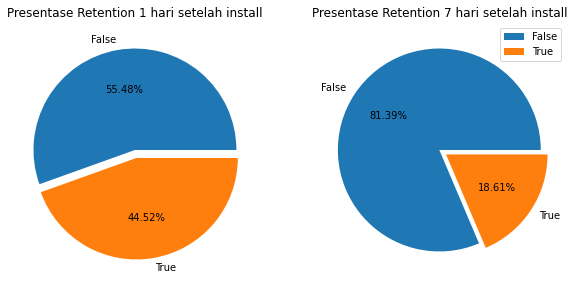

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
ax1, ax2 = axes 

explode1 = [0.0, 0.08]
explode2 = [0.0, 0.08]

labels = ['False', 'True']
ax1.pie(retention_1, labels = labels, explode=explode1, 
        autopct='%.2f%%')
ax2.pie(retention_7, labels = labels, explode=explode2, 
        autopct='%.2f%%')
ax1.set_title('Presentase Retention 1 hari setelah install')
ax2.set_title('Presentase Retention 7 hari setelah install')
plt.legend()

## User yang tidak bermain sama sekali jumlah ronde == 0

In [ ]:
nol_round = data_clear[data_clear["sum_gamerounds"]== 0]["userid"].count()
print(nol_round)

3994


In [ ]:
nnol_round = data_clear[data_clear["sum_gamerounds"]!= 0]["userid"].count()
print(nnol_round)

86194


Text(0.5, 0, 'kategori ronde')

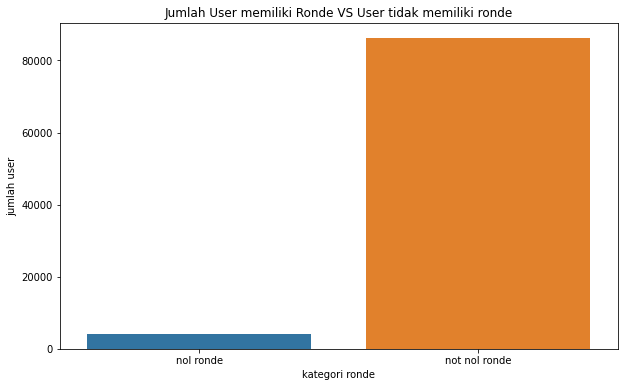

In [ ]:
plt.figure(figsize=(10,6))
plt.title("Jumlah User memiliki Ronde VS User tidak memiliki ronde")
ax = sns.barplot(x = ["nol ronde", "not nol ronde"], y = [nol_round, nnol_round])
plt.ylabel("jumlah user")
plt.xlabel("kategori ronde")

## Import Data After Preprocessing at SQL, to delete row data that contains FALSE in retention_1, and have sum round == 0

In [18]:
data_final = pd.read_csv("/content/drive/MyDrive/Generasi Gigih/Last Showcase/cats_clean_rev2.csv")

In [ ]:
retention_1 = data_final['retention_1'].value_counts()
print(retention_1)

t    40066
Name: retention_1, dtype: int64


In [ ]:
retention_7 = data_final['retention_7'].value_counts()
print(retention_7)

f    26889
t    13177
Name: retention_7, dtype: int64


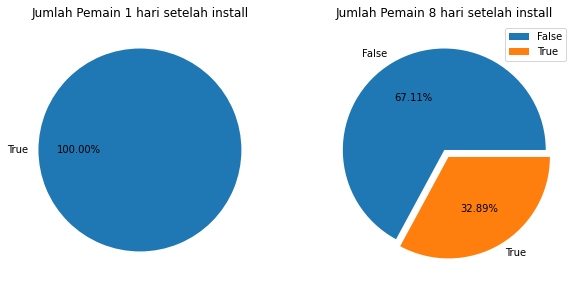

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
ax1, ax2 = axes 


explode2 = [0.0, 0.08]

labels1 = ['True']
labels2 = ['False','True']
ax1.pie(retention_1, labels = labels1, 
        autopct='%.2f%%')
ax2.pie(retention_7, labels = labels2, explode=explode2, 
        autopct='%.2f%%')
ax1.set_title('Jumlah Pemain 1 hari setelah install')
ax2.set_title('Jumlah Pemain 8 hari setelah install')
plt.legend()

## Cek Jumlah Data di masing-masing Gate

In [ ]:
data_final.groupby('version').userid.agg(['count']).T

version,gate_30,gate_40
count,19993,20073


In [ ]:
# CEK VERSION

data_final.groupby("version").sum_gameround.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,19993,48.0,94.605312,135.108323,2961
gate_40,20073,50.0,95.599761,137.969457,2640


In [ ]:
data_final[data_final.userid == 337]

,no,userid,version,sum_gameround,retention_1,retention_7
0,1,337,gate_30,38,t,f


## Hapus Data sehingga memiliki distribusi data 50% Gate_30 dan 50% Gate 40

In [19]:
# delete gate_40 sebanyak 80 baris

specific_data_delete = data_final[data_final.version == "gate_40"][0:80].index
print(specific_data_delete)

Int64Index([  1,   2,   3,   4,   5,   6,  13,  15,  16,  17,  20,  21,  23,
             30,  32,  33,  34,  35,  41,  42,  43,  46,  47,  59,  60,  62,
             63,  65,  67,  70,  72,  73,  74,  77,  78,  80,  81,  84,  85,
             87,  88,  90,  91,  92,  94,  96,  97,  98, 100, 104, 106, 107,
            112, 113, 116, 118, 123, 129, 130, 131, 132, 133, 134, 135, 136,
            138, 139, 141, 143, 145, 152, 156, 157, 159, 160, 161, 163, 169,
            172, 173],
           dtype='int64')


In [20]:
# delete gate_40 sebanyak 80 baris
data_final_4 = data_final.drop(specific_data_delete)

## Cek Deskripsi masing-masing variabel di dataset final_5

In [21]:
data_final_4.groupby('version').userid.agg(['count']).T

version,gate_30,gate_40
count,19993,19993


In [ ]:
# CEK VERSION

data_final_4.groupby("version").sum_gameround.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,19993,48.0,94.605312,135.108323,2961
gate_40,19993,50.0,95.657580,138.094553,2640


## Replace retention dengan nilai True = 1 dan False = 0

In [22]:
# replace t and f to 1 and 0

data_final_5 = data_final_4.replace(to_replace =["t", "f"], 
                            value =[1, 0])

In [23]:
data_final_5.head()

,no,userid,version,sum_gameround,retention_1,retention_7
0,1,337,gate_30,38,1,0
7,13,2179,gate_30,39,1,0
8,14,2218,gate_30,305,1,1
9,15,2382,gate_30,73,1,0
10,16,2392,gate_30,14,1,0


## Save Dataset Hasil Preprocessing Lanjutan

In [ ]:
# save to csv final data 4
data_final_5.to_csv('/content/drive/MyDrive/Generasi Gigih/Last Showcase/cats_clean_rev6.csv')

In [ ]:
data_final_5 = pd.read_csv("/content/drive/MyDrive/Generasi Gigih/Last Showcase/cats_clean_rev6.csv")

# 4. Sample Ratio Missmatch

Note: digunakan untuk mencek apakah antara 2 variabel yaitu variabel control dan variabel treatment memiliki distribusi yang sama

In [ ]:

def SRMcheck(df):
    num_A = df["version"].value_counts().loc["gate_30"]
    num_B = df["version"].value_counts().loc["gate_40"]

    print("Number of players in gate_30:",num_A)
    print("Number of players in gate_40:",num_B)
    print("A/B ratio: {:.5f}".format(num_A/num_B))
    print("-"*45)
    
    observed = [ num_A, num_B ]
    total_player= sum(observed)
    expected = [ total_player/2, total_player/2 ]

    chi = chisquare(observed, f_exp=expected)
    print("pvalue: {:.3f}".format(chi[1]))
    print("*"*15)
    if chi[1] < 0.01:
        print('Sample Ratio Missmatch may be present.')
    else:
        print('Probably no Sample Ratio Missmatch.')

In [ ]:
# Check SRM

SRMcheck(data_final_5)

Number of players in gate_30: 19993
Number of players in gate_40: 19993
A/B ratio: 1.00000
---------------------------------------------
pvalue: 1.000
***************
Probably no Sample Ratio Missmatch.


# 5. Observasi Lebih Mendetail

## banyaknya jumlah ronde yang dimainkan sejak hari pertama dan hari ke 7

In [26]:
data_final_5.groupby(['version','retention_1']).sum_gameround.agg(['mean'])

,,mean
version,retention_1,
gate_30,1,94.605312
gate_40,1,95.657580


In [27]:
data_final_5.groupby(['version', 'retention_7']).sum_gameround.agg(['mean'])

mean
version retention_7            
gate_30 0             49.843745
        1            183.913858
gate_40 0             50.221885
        1            190.471360

## Jumlah Game Round di keseluruhan Retensi 

In [25]:
data_final_5.groupby("version").sum_gameround.agg(["median", "mean"])

,median,mean
version,,
gate_30,48.0,94.605312
gate_40,50.0,95.657580


## Rata-rata Retensi hari ke-1, dan hari ke-7

In [ ]:
df_retention_ab = data_final_5.groupby("version").agg({"userid":"count", "retention_1":"mean","retention_7":"mean", "sum_gameround":"sum"})
df_retention_ab

,userid,retention_1,retention_7,sum_gameround
version,,,,
gate_30,19993,1.0,0.333867,1891444
gate_40,19993,1.0,0.323963,1912482


## Cek Kepadatan Distribusi pada retention 7

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

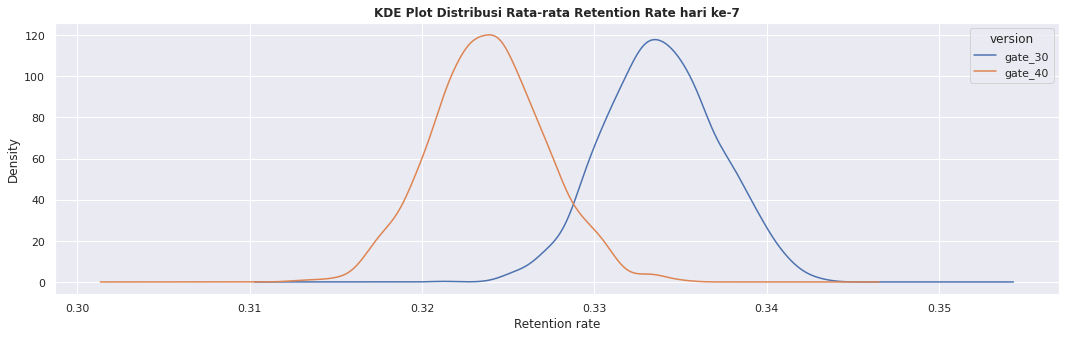

In [ ]:
bootstrap_retention7=pd.DataFrame([data_final_5.sample(frac=1, replace=True).groupby('version')['retention_7'].mean() for i in range(2000)])

bootstrap_retention7.plot.kde()
sns.set(rc={'figure.figsize':(18,5)})
plt.title("KDE Plot Distribusi Rata-rata Retention Rate hari ke-7", fontweight="bold")
plt.xlabel("Retention rate")
plt.show()

## Cek Kepadatan Gameround

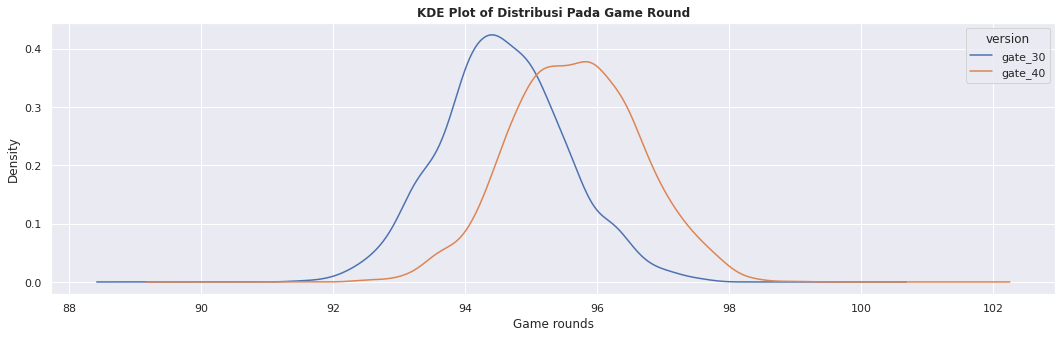

In [ ]:
bootstrap_sum=pd.DataFrame([data_final_5.sample(frac=1, replace=True).groupby('version')['sum_gameround'].mean() for i in range(2000)])

bootstrap_sum.plot.kde()
sns.set(rc={'figure.figsize':(18,5)})
plt.title("KDE Plot of Distribusi Pada Game Round", fontweight="bold")
plt.xlabel("Game rounds")
plt.show()

## Hubungan Jumlah User dengan banyaknya rounde

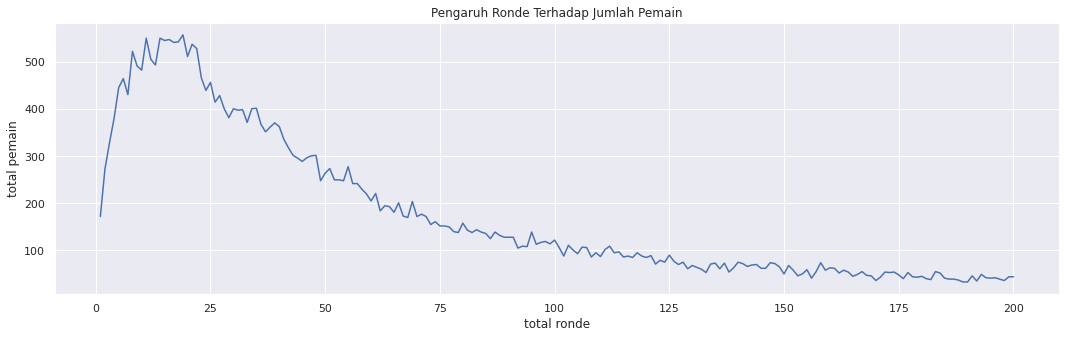

In [ ]:

new_data  = data_final_5[["userid","sum_gameround"]].groupby("sum_gameround").count().reset_index().rename(columns = {"userid":"count"})[0:200]

plt.xlabel("total ronde")
plt.ylabel("total pemain")

plt.title("Pengaruh Ronde Terhadap Jumlah Pemain")
plt.plot(new_data["sum_gameround"],new_data["count"])

# 6. Analysis Chi-Square

## Chi Square Versi 1

H0 : Gate 40 tidak lebih dalam meningkatkan retention rate

H1 : Gate 40 lebih baik dalam meningkatkan retention rate

In [44]:
# import module 

import statsmodels.api as sm
from scipy.stats import chisquare
from scipy.stats import chi2_contingency

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [45]:
# Function for Chi-square test of independence of variables in a contingency table

def chi2test(data):
    _, p, _, _ = chi2_contingency(data)
    alpha = 0.05

    print('p=%.4f , alpha=%.2f '%(p,alpha))
    if p > alpha:
        print('Two groups have no significant difference')
    else:
        print('Two groups have a significant difference')

In [ ]:
#Chi-square test for retention_1 

cross1 = pd.crosstab(data_final_5["version"], data_final_5["retention_7"])
chi2test(cross1)

p=0.0360 , alpha=0.05 
Two groups have a significant difference


### Retention 1

In [46]:
cross_ret1 = pd.crosstab(data_final_5["version"], data_final_5["retention_1"])
chi2test(cross_ret1)

p=1.0000 , alpha=0.05 
Two groups have no significant difference


## Chi Square Versi 2

In [37]:
# Import libraries for chi-square test
import numpy as np
import scipy as sp
import scipy.stats

In [ ]:
# Calculate chi-square,p-value, degree of freedom, and expected
x2, p, dof, expected = sp.stats.chi2_contingency(cross1,correction=False)

In [ ]:
# Test the hypothesis by chi-square test
print("Chi-square: %(x2)s" %locals() )
print("p-value: %(p)s" %locals() )
print("Degree of freedom: %(dof)s" %locals() )
print(expected)

if p < 0.01:
    print("Significant at 1% level of significance")
elif p < 0.05:
    print("Significant at 5% level of significance")
else:
    print("Not significant at 5% level of significance")

Chi-square: 4.4418217519009815
p-value: 0.035068807842018185
Degree of freedom: 1
[[13417.  6576.]
 [13417.  6576.]]
Significant at 5% level of significance


### Retention 1

In [42]:
cross_ret1 = pd.crosstab(data_final_5["version"], data_final_5["retention_1"])

In [43]:
x2, p, dof, expected = sp.stats.chi2_contingency(cross_ret1,correction=False)

# Test the hypothesis by chi-square test
print("Chi-square: %(x2)s" %locals() )
print("p-value: %(p)s" %locals() )
print("Degree of freedom: %(dof)s" %locals() )
print(expected)

if p < 0.01:
    print("Significant at 1% level of significance")
elif p < 0.05:
    print("Significant at 5% level of significance")
else:
    print("Not significant at 5% level of significance")

Chi-square: 0.0
p-value: 1.0
Degree of freedom: 0
[[19993.]
 [19993.]]
Not significant at 5% level of significance


## Permutation

In [28]:
def permutation_sample(data1, data2):
    """Generate a permutation sample from two datasets"""
    
    # Concatenate the datasets: data
    data = np.concatenate((data1, data2))
    
    # Permute the data: permuted_data
    permuated_data = np.random.permutation(data)
    
    # Split the permuted_data into two: perm_sample_1 and perm_sample_2
    perm_sample_1 = permuated_data[:len(data1)]
    perm_sample_2 = permuated_data[len(data1):]
    
    return perm_sample_1, perm_sample_2

In [29]:
def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates

In [30]:
def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""

    # The difference of means of data_1, data_2: diff
    diff = np.mean(data_1) - np.mean(data_2)

    return diff

In [31]:
# Get both the retention data of "gate_30" and "gate_40"
gate30 = data_final_5[data_final_5['version']=='gate_30']['retention_1']
gate40 = data_final_5[data_final_5['version']=='gate_40']['retention_1']

# Compute difference of mean impact force from experiment: empirical_diff_means
empirical_diff_means = diff_of_means(gate30, gate40)

# Draw 10,000 permutation replicates: perm_replicates
perm_replicates = draw_perm_reps(gate30, gate40,
                                 diff_of_means, size=10000)

# Compute p-value: p
p = np.sum(perm_replicates >= empirical_diff_means) / len(perm_replicates)

# Print the result
print('p-value =', p)

p-value = 1.0


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


TypeError: ignored

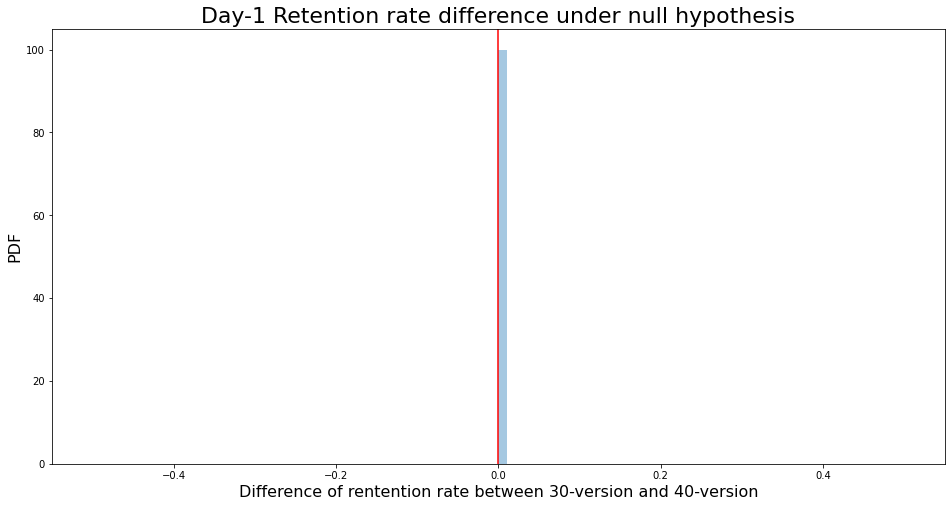

In [32]:
# Visualize the simulation result
plt.figure(figsize=(16, 8))
sns.distplot(perm_replicates, norm_hist=True, bins=100)

# Label the chart
plt.xlabel('Difference of rentention rate between 30-version and 40-version', size=16)
plt.ylabel('PDF', size=16)
plt.title('Day-1 Retention rate difference under null hypothesis', size=22)
plt.axvline(x=empirical_diff_means, color='r')
plt.annotate(text='p-value', 
             xy=(0.008, 5), 
             xytext=(0.010, 15), 
             color='r', 
             size=20,
             arrowprops={'arrowstyle':'fancy', 'color':'r'})

In [35]:
# RETENTION_7

gate30 = data_final_5[data_final_5['version']=='gate_30']['retention_7']
gate40 = data_final_5[data_final_5['version']=='gate_40']['retention_7']

# Compute difference of mean impact force from experiment: empirical_diff_means
empirical_diff_means = diff_of_means(gate30, gate40)

# Draw 10,000 permutation replicates: perm_replicates
perm_replicates = draw_perm_reps(gate30, gate40,
                                 diff_of_means, size=39986)

# Compute p-value: p
p = np.sum(perm_replicates >= empirical_diff_means) / len(perm_replicates)

# Print the result
print('p-value =', p)

p-value = 0.017055969589356276


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


TypeError: ignored

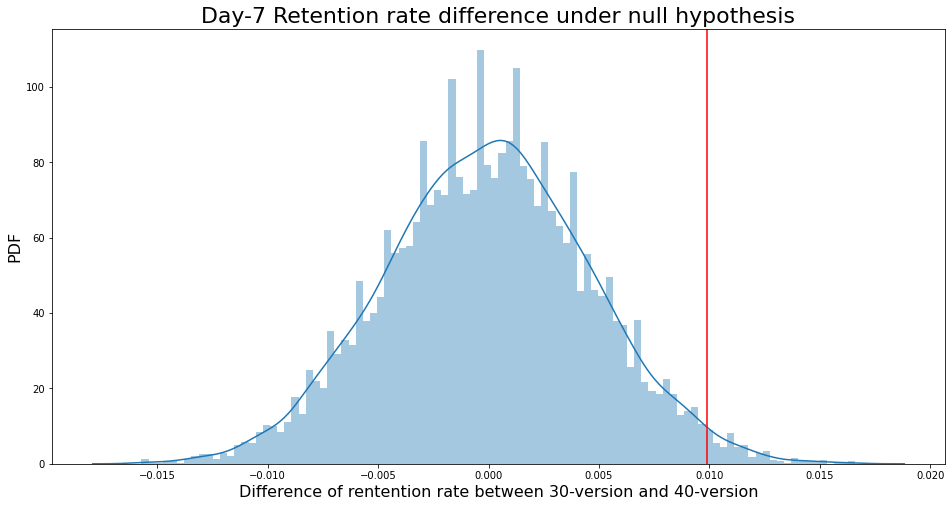

In [34]:
# Visualize the simulation result
plt.figure(figsize=(16, 8))
sns.distplot(perm_replicates, norm_hist=True, bins=100)

# Label the chart
plt.xlabel('Difference of rentention rate between 30-version and 40-version', size=16)
plt.ylabel('PDF', size=16)
plt.title('Day-7 Retention rate difference under null hypothesis', size=22)
plt.axvline(x=empirical_diff_means, color='r')
plt.annotate(text='p-value', 
             xy=(0.009, 1), 
             xytext=(0.009, 15), 
             color='r', 
             size=20,
             arrowprops={'arrowstyle':'fancy', 'color':'r'})